In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d omkargurav/face-mask-dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 96% 156M/163M [00:01<00:00, 110MB/s]
100% 163M/163M [00:01<00:00, 129MB/s]


In [3]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [4]:
# Load dataset and preprocess images
def load_and_preprocess_data(data_dir):
    categories = ['with_mask', 'without_mask']
    data = []
    labels = []

    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                img_resized = cv2.resize(img_array, (128, 128))
                data.append(img_resized)
                labels.append(class_num)
            except Exception as e:
                pass

    data = np.array(data) / 255.0
    labels = to_categorical(labels, num_classes=2)

    return data, labels

In [5]:
data_dir = './data'  # path to the extracted dataset
X, y = load_and_preprocess_data(data_dir)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)

In [6]:
base_model = VGG19(include_top=False, weights="imagenet", input_shape=(128, 128, 3))


80134624/80134624 [==============================] - 1s 0us/step


In [7]:
for layer in base_model.layers:
    layer.trainable = False

In [8]:
from keras.layers import Dropout

x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(512, activation='relu')(x)  # Adding another dense layer
x = Dropout(0.3)(x)  # Adding dropout for regularization
x = Dense(256, activation='relu')(x)  # Adding another dense layer
predictions = Dense(2, activation='sigmoid')(x)  # Corrected activation function

model = Model(inputs=base_model.input, outputs=predictions)


In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=64), epochs = 10, validation_data=(X_test, y_test),validation_split=0.2)


Epoch 1/10
95/95 [==============================] - 54s 462ms/step - loss: 0.3275 - accuracy: 0.8611 - val_loss: 0.1465 - val_accuracy: 0.9424
Epoch 2/10
95/95 [==============================] - 32s 340ms/step - loss: 0.1932 - accuracy: 0.9194 - val_loss: 0.0953 - val_accuracy: 0.9543
Epoch 3/10
95/95 [==============================] - 32s 339ms/step - loss: 0.1722 - accuracy: 0.9308 - val_loss: 0.0860 - val_accuracy: 0.9629
Epoch 4/10
95/95 [==============================] - 33s 343ms/step - loss: 0.1725 - accuracy: 0.9313 - val_loss: 0.0843 - val_accuracy: 0.9676
Epoch 5/10
95/95 [==============================] - 33s 348ms/step - loss: 0.1588 - accuracy: 0.9351 - val_loss: 0.0780 - val_accuracy: 0.9676
Epoch 6/10
95/95 [==============================] - 34s 354ms/step - loss: 0.1592 - accuracy: 0.9333 - val_loss: 0.0901 - val_accuracy: 0.9616
Epoch 7/10
95/95 [==============================] - 32s 334ms/step - loss: 0.1340 - accuracy: 0.9474 - val_loss: 0.0942 - val_accuracy: 0.9603

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


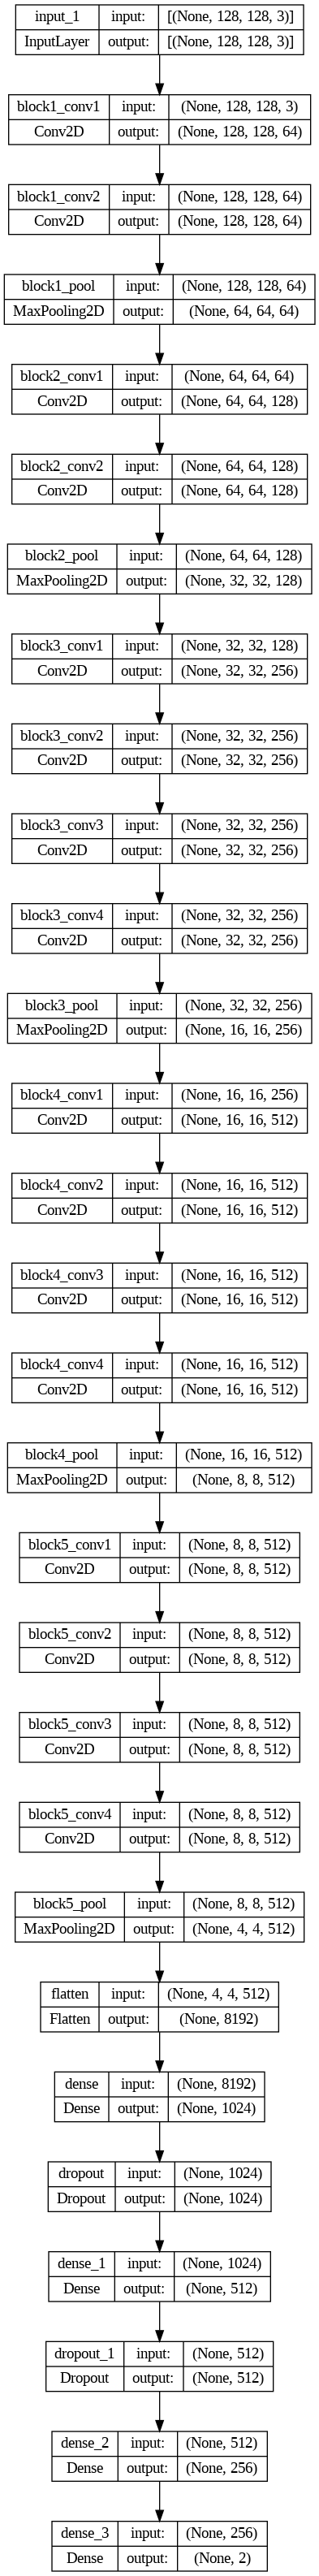

In [11]:
model.summary()
model.save('face_mask_model_dropout.h5')
    # Visualize the model
visualization_path = 'model_visualization.png'
tf.keras.utils.plot_model(model, to_file=visualization_path, show_shapes=True, show_layer_names=True)

48/48 [==============================] - 3s 55ms/step - loss: 0.0707 - accuracy: 0.9729
Loss: 0.07072808593511581, Accuracy: 0.972865641117096


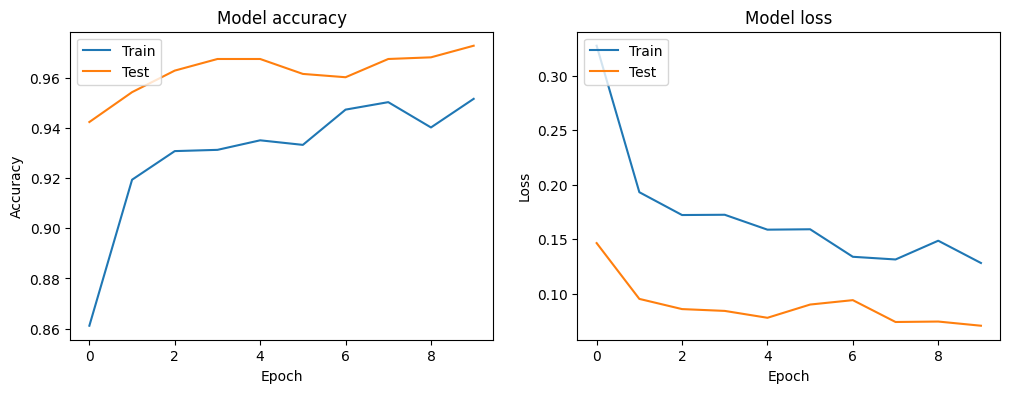

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


48/48 [==============================] - 3s 52ms/step


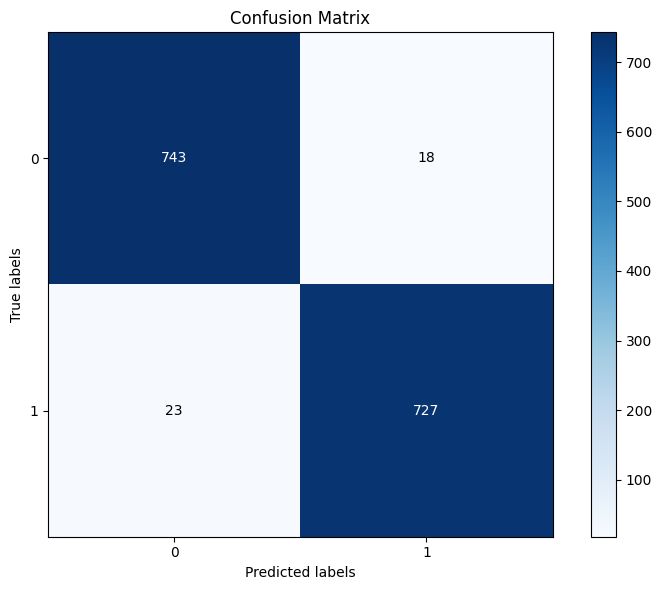


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       761
           1       0.98      0.97      0.97       750

    accuracy                           0.97      1511
   macro avg       0.97      0.97      0.97      1511
weighted avg       0.97      0.97      0.97      1511


Accuracy: 0.9728656518861681


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predict classes for test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix as Matplotlib Image
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding Labels
num_classes = len(np.unique(y_true))
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))

# Adding Text Annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.tight_layout()

# Save as Image or Show
# plt.savefig('confusion_matrix.png')  # Save as Image
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("\nAccuracy:", accuracy)

In [14]:
# Predicting new images
from keras.preprocessing import image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0
    return img_tensor

def predict_images(img_paths, model):
    predictions = []
    for img_path in img_paths:
        img_tensor = load_image(img_path)
        prediction = model.predict(img_tensor)

        class_names = ['With Mask', 'Without Mask']
        predicted_class = class_names[np.argmax(prediction)]
        confidence = np.max(prediction) * 100

        predictions.append((img_path, predicted_class, confidence))

    return predictions



1/1 [==============================] - 0s 427ms/step


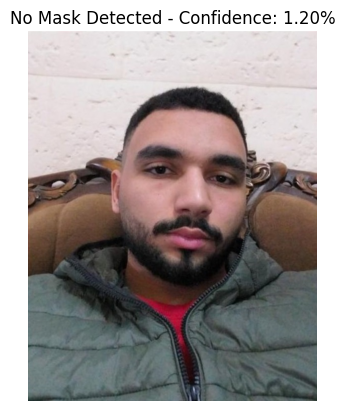

1/1 [==============================] - 0s 31ms/step


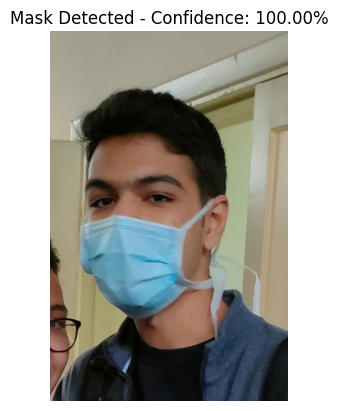

1/1 [==============================] - 0s 36ms/step


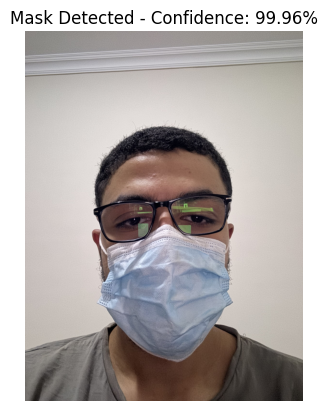

1/1 [==============================] - 0s 20ms/step


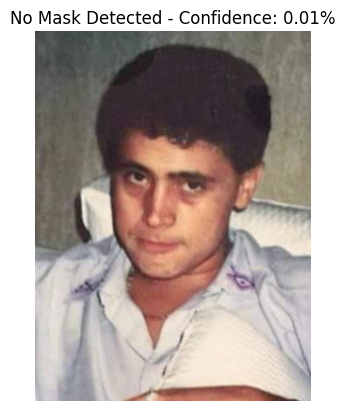

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the trained model
model = load_model('face_mask_model_dropout.h5')

# Function to preprocess the input image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize
    return img

# Function to make predictions
# Function to make predictions
def predict_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    confidence_percentage = prediction[0][0] * 100
    if confidence_percentage > 50:  # Checking confidence percentage
        label = "Mask Detected"
    else:
        label = "No Mask Detected"
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'{label} - Confidence: {confidence_percentage:.2f}%')
    plt.show()


# Example usage:
image_paths = ["/content/disha.jpeg", "/content/guymask.jpeg", "/content/amrmask.jpg", "/content/john.jpeg"]

for image_path in image_paths:
    predict_image(image_path)
